# 线性神经网络

## 一、 线性回归

1. 基本元素
- 线性模型：y为关于x输入向量的加权线性和得到的输出/严格来说，是输入特征的一个仿射变换（affinetransformation）。仿射变换的特点是通过
加权和对特征进行线性变换（lineartransformation），并通过偏置项来进行平移（translation）
- 损失函数：均方误差（MSE）→ 解析解求最优参数；其余一些损失函数无法得到解析解 → 梯度下降法；
2. 矢量化加速 （把数据变成一个矢量而不是一位一位的去计算）

In [56]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [57]:
class Timer:  # @save
    """记录多次运行时间"""

    def __init__(self):
        self.times = []
        self.start()  #  Python 会自动帮你把在 __init__ 里首次赋值的变量当成实例成员变量

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

3. 正态分布

In [58]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu) ** 2)

In [59]:
# 再次使用numpy进行可视化
x = np.arange(
    -7, 7, 0.01
)  # 从 -7 开始，到 7 结束（不包括 7），步长为 0.01，得到一个包含很多浮点数的数组，

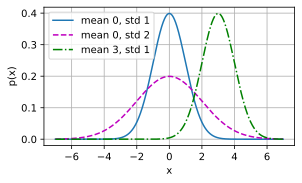

In [60]:
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(# 作图函数
    x,# 自变量
    [normal(x, mu, sigma) for mu, sigma in params],# 因变量
    xlabel="x",
    ylabel="p(x)",
    figsize=(4.5, 2.5),  # 图像大小
    legend=[f"mean {mu}, std {sigma}" for mu, sigma in params],# 图例
)

## 二、 线性回归代码
   

1. 生成数据集

In [61]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [62]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成一个形状为 (num_examples, len(w)) 的随机矩阵 每个元素来自 𝒩(0,1) 的标准正态分布
    y = torch.matmul(X, w) + b # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 生成与 y 形状相同的随机噪声并加到 y 上
    return X, y.reshape((-1, 1))


In [63]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [64]:
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([ 0.2372, -0.5654]) 
label: tensor([6.6060])


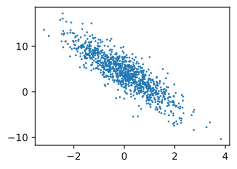

In [65]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)


2. 读取数据集

In [66]:
def data_iter(batch_size, features, labels): #@save
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # 步长为 batch_size
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)]) # 这里冒号是python中list的切片操作
        yield features[batch_indices], labels[batch_indices] # 通过yield关键字将函数变成一个生成器，一批一批地返回数据

3. 初始化参数

In [67]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True) # 只有需要自动优化、参与训练的参数才要设置 requires_grad=True

4. 定义线性模型（前面的y=Xw+b+噪声是人工造数据用的，在真实情况下直接用真数据，这里才开始建模根据feature和w去预测y得到y_hat）

In [68]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b # 这里运用了广播机制，b会自动扩展成和Xw同样的形状（向量）再做加法

5. 定义损失函数（均方误差）

In [69]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

6. 定义优化算法（梯度下降）

In [70]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    # lr: learning rate 决定了每次更新的幅度
    # batch_size: 每个小批量包含的样本数
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 因为在初始化 w 和 b 时设置了 requires_grad=True，所以在后续计算损失函数时，PyTorch 会自动追踪所有涉及 w 和 b 的运算过程
                                                  # 这里之所以要除以 batch_size，是因为 loss 的计算是对一个小批量样本的损失求和得到的，而我们希望更新的步伐与样本数无关
                                                  # 这里的grad是损失函数对param的偏导数
            param.grad.zero_() # 梯度清零，否则梯度会累加


7. 训练模型

In [71]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

In [72]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward() # 这里用backward()之后就相当于自动计算了l对w和b的梯度，存储在w.grad和b.grad中
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032765
epoch 2, loss 0.000116
epoch 3, loss 0.000051


In [73]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0007], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


## 三、 线性回归封装

In [74]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)


In [75]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    # 把取batch的过程好了
    # is_train参数指明在每一个epoch结束后是否需要打乱数据
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)


In [76]:
list(iter(data_iter))

[[tensor([[-1.4958,  1.4691],
          [-0.2573, -0.4814],
          [-0.6753,  2.1756],
          [-1.0683,  1.2498],
          [-0.8047, -1.5690],
          [ 1.2952, -0.7898],
          [ 1.6378, -1.8083],
          [ 0.9681, -0.7308],
          [-0.4624,  0.0915],
          [-1.8010,  0.0788]]),
  tensor([[-3.7855],
          [ 5.3273],
          [-4.5329],
          [-2.1744],
          [ 7.9329],
          [ 9.4925],
          [13.6208],
          [ 8.6242],
          [ 2.9533],
          [ 0.3429]])],
 [tensor([[-0.7244, -0.2136],
          [ 0.3116, -0.3155],
          [ 0.5573,  0.1313],
          [ 1.8985,  0.7614],
          [-0.6163, -2.6794],
          [-0.6862,  0.0285],
          [ 0.5542, -1.1201],
          [-1.0190,  1.0332],
          [-0.6234,  1.3868],
          [-0.8989, -0.7816]]),
  tensor([[ 3.4814],
          [ 5.8774],
          [ 4.8678],
          [ 5.4025],
          [12.0802],
          [ 2.7289],
          [ 9.1231],
          [-1.3469],
          [-1.7

In [77]:
next(iter(data_iter)) # 通过Python内置函数iter()和next()可以不断从迭代器（DataLoader）data_iter中获取小批量样本 标准用法

[tensor([[ 1.4752, -1.4275],
         [ 1.8802, -1.3122],
         [ 0.7496,  0.7105],
         [-1.6759,  1.4954],
         [-0.3280, -0.8061],
         [-1.8010,  0.0788],
         [ 1.2447, -1.4702],
         [ 1.0212,  0.6745],
         [ 2.4365,  1.2870],
         [-0.2042,  0.6623]]),
 tensor([[12.0138],
         [12.4249],
         [ 3.2673],
         [-4.2509],
         [ 6.2697],
         [ 0.3429],
         [11.6947],
         [ 3.9503],
         [ 4.6971],
         [ 1.5388]])]

定义模型

In [78]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
# Sequential是一个类，将多个层串联在一起
# Linear是一个类，表示全连接层，两个参数表示输入和输出的维度

In [79]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
# net[0]表示取net的第一个层，即上面的Linear层

tensor([0.])

In [80]:
loss = nn.MSELoss() # 封装好的损失函数

In [81]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# optim是torch中封装好的优化算法模块
# net.parameters() 会返回模型 net 中所有需要优化的参数（如权重和偏置），这些参数会被优化器管理和更新

训练

In [82]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter: # data_iter 作为torch的DataLoader每次迭代返回的就是 (X, y) 元组
        l = loss(net(X) ,y)
        trainer.zero_grad() # 优化器梯度清零
        l.backward() # 自动计算梯度
        trainer.step() # 根据梯度更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000195
epoch 2, loss 0.000097
epoch 3, loss 0.000096


## 四、 Softmax回归

1. 分类问题表示：
one-hot encoding（独热编码）：编码一个向量，向量中只有一个元素为1，其余元素为0，表示一个类别

2. 网络架构

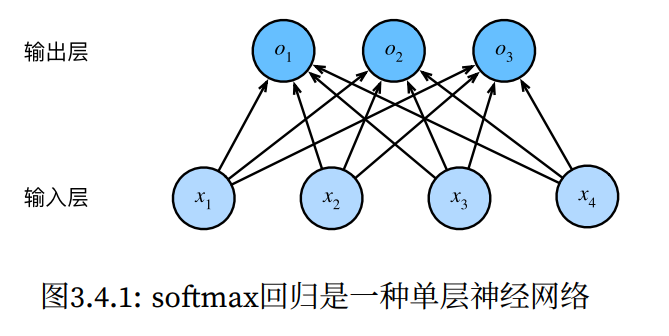

o = Wx + b  这里为什么要有3个输出??
→这里是针对one-hot encoding的，有3个输出，每个输出对应一个类别，输出向量o的每个元素对应一个类别的得分，后面通过softmax可以把这个得分变成属于这个类别的概率

3. softmax： 其实还是在仿射变换（线性变换+平移）的基础上加了一个softmax函数，softmax函数可以把得分变成概率，且概率之和为1

4. 损失函数：交叉熵函数？）

## 五、 图像分类数据集

1. 读取数据集

In [83]:
%matplotlib inline  
# Jupyter Notebook 的魔法命令，用于设置 Matplotlib 绘图时将图像直接嵌入在代码单元下方，而不是弹出单独的窗口
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display() # 用于设置 Jupyter Notebook 中 Matplotlib 绘图的显示格式为 SVG

In [84]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor() # 把图像数据从PIL类型变换成每一位为32位浮点数格式的张量，并除以255使得所有像素的数值均在0～1之间
mnist_train = torchvision.datasets.FashionMNIST(
    root="../C2data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../C2data", train=False, transform=trans, download=True)


In [85]:
x, y = mnist_train[0]

print(type(y))      # <class 'int'>  或 <class 'torch.Tensor'> 取决于 torchvision 版本
print(y)  

<class 'int'>
9


In [86]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [87]:
mnist_train[0][0].shape # (1, 28, 28) 1表示通道数，灰度图像只有一个通道，彩色图像有3个通道，分别对应RGB三种颜色
# 28*28表示图像的分辨率(简单理解就是高度和宽度)
# 这里mnist_train[0]表示取训练集的第一个样本，mnist_train[0][0]表示取这个样本的图像数据，mnist_train[0][1]表示取这个样本的标签
# 也就是说mnist_train[0]表示取训练集的第一个样本是一个元组

torch.Size([1, 28, 28])

In [88]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
# 建立one-hot encoding的标签 
# 问题是这里传进来的labels就是一个int的list，每一个int代表一个类别，0-9分别对应上面的10个类别，那不就不是one-hot encoding了吗？


In [89]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    # fig是全图 axes是子图 相当于fig里面有num_rows行num_cols列的子图axes
    figsize = (num_cols * scale, num_rows * scale) # 所以这里的scale是每个子图的大小，1.5指的是英寸
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)): # 这里的zip是python内置函数，可以把两个list打包成一个list，里面的每个元素是一个tuple
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.get_xaxis().set_visible(False) # 不显示坐标轴
        ax.get_yaxis().set_visible(False) 
        if titles:
            ax.set_title(titles[i]) # 设置子图标题
    return axes


array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

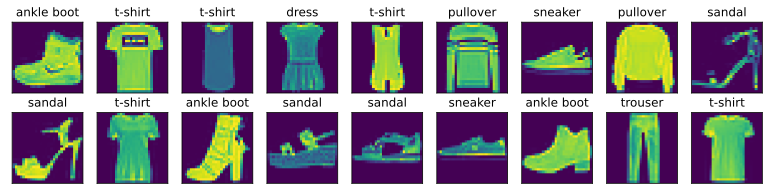

In [90]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y)) # 所以这里y存的实际是数字标签，而不是one-hot encoding

前面只是展示了一下下载下来的数据集，在真正训练的时候还是使用内置的迭代器 DataaLoader，这个迭代器会帮我们自动打乱数据，并每次返回一个batch的数据

In [91]:
batch_size = 256
def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
    num_workers=get_dataloader_workers())

In [93]:
timer = d2l.Timer()
for X, y in train_iter:
    continue # 相当于在遍历迭代器
f'{timer.stop():.2f} sec'


'5.75 sec'

## 六、 Softmax回归的从零开始实现

1. 差别：output变成向量且经过softmax标准化；损失函数变成交叉熵损失函数；损失函数的输入变成one-hot encoding的标签

2. trick：定义模型精度

In [ ]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # axis=1表示按行取最大值，返回的是每一行的最大值的索引，也就是预测的类别
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())

In [3]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # 这里zip函数会返回一个list，里面的每个元素是一个tuple，tuple的第一个元素是self.data的元素，第二个元素是args的元素；也就是说zip把两个list打包成一个list，里面的每个元素是一个tuple，tuple的第一个元素是self.data的元素，第二个元素是args的元素
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module): # 判断 net 是不是一个 PyTorch 模型（torch.nn.Module 的子类），只有这种类型的对象才有 net.eval() 这个方法
        net.eval() # 将模型设置为评估模式，这里不再训练，不会改动模型
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad(): # 表明下面不是在训练，而是用已经训练好的模型检测，所以不用计算梯度。否则会自动计算占用空间之类的
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # 每一个batch的预测正确的数量和预测总数都累加到metric中
    return metric[0] / metric[1] # 这里的metric[0]表示正确预测总数，metric[1]表示预测总数

3. 实现

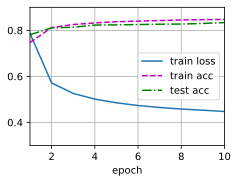

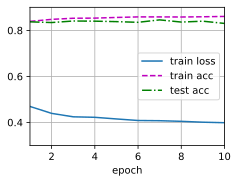

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256

# 1. 加载数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
X, y = next(iter(train_iter))

# 2. 定义模型
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

# 3. 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights) # 对net中的所有参数进行初始化

# 4. 定义损失函数 这里说了上溢和下溢的事情，具体细节还没理解
loss = nn.CrossEntropyLoss(reduction='none') # PyTorch 自带的交叉熵损失函数
# reduction='none' 表示不对 batch 内的样本损失做平均或求和，而是逐样本返回原始损失——得到一个形状为 [batch_size] 的张量

# 5. 定义优化器
trainer1 = torch.optim.SGD(net.parameters(), lr=0.1)
trainer2 = torch.optim.Adam(net.parameters(), lr=0.01)

# 6. 训练模型
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer1)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer2)
# 这里d2l帮忙封装好了，实际的过程在每一个epoch中训练（定义优化、损失）→检测（loss，accu）→绘图